# HEADWAYS ANALYSIS

In [286]:
import pandas as pd

import numpy as np
from numpy import pi, sin, cos

import json

import datetime
from datetime import timedelta

import statistics
from statistics import mean
import math

from pandarallel import pandarallel
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
pandarallel.initialize()

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.templates.default = 'plotly_white'
pd.set_option("display.precision", 3)

import matplotlib

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import scipy
from scipy import stats
import statsmodels.api as sm
import pylab
from scipy.stats.distributions import chi2

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [181]:
#Available colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

In [381]:
# FUNCTIONS 
def conf_ellipse_params(df,conf) :
    col1 = df.iloc[:,0]
    col2 = df.iloc[:,1]
    
    #Mean values for the center of the ellipse
    mu1 = col1.mean()
    mu2 = col2.mean()
    mus = [mu1,mu2]
    
    # Columns covariance matrix
    cov_mat = np.stack((h1, h2), axis = 0)  
    cov_matrix = np.cov(cov_mat)
    
    a = cov_matrix[0][0]
    b = cov_matrix[0][1]
    c = cov_matrix[1][1]
    
    lambda1 = (a+c)/2 + math.sqrt(((a-c)/2)**2 + b**2)
    lambda2 = (a+c)/2 - math.sqrt(((a-c)/2)**2 + b**2)
    
    #Rotation angle
    if (b == 0) and (a >= c) :
        theta = 0
    elif (b == 0) and (a < c) :
        theta = math.pi/2
    else :
        theta = math.atan2(lambda1-a,b)
    
    #Eigenvectors
    ei_vecs = [
        [math.cos(theta),-math.sin(theta)],
        [math.sin(theta),math.cos(theta)]
    ]
    
    #Chi-Value for desired confidence
    chi_val = chi2.ppf(conf, df=2)
    
    #Eigenvalues
    r1 = math.sqrt(chi_val*lambda1)
    r2 = math.sqrt(chi_val*lambda2)
    ei_vals = [r1,r2]
    
    return theta,mus,ei_vecs,ei_vals

#Get N equiespaciated points of the ellipse
def ellipse(mus=[0,0], ei_vecs=[[1,0],[0,1]], ei_vals=[1,1],  N=100):
    # x_center, y_center the coordinates of ellipse center
    # ax1 ax2 two orthonormal vectors representing the ellipse axis directions
    # a, b the ellipse parameters
    t = np.linspace(0, 2*pi, N)
    #ellipse parameterization with respect to a system of axes of directions a1, a2
    xs = ei_vals[0] * cos(t)
    ys = ei_vals[1] * sin(t)
    # coordinate of the  ellipse points with respect to the system of axes [1, 0], [0,1] with origin (0,0)
    xp, yp = np.dot(ei_vecs, [xs, ys])
    x = xp + mus[0] 
    y = yp + mus[1]
    return x, y

#Returns true if the given value is inside the ellipse
def inside(ellipse_params,x,y):
    mus,ei_vecs,ei_vals = ellipse_params
    h,k = mus
    a,b = ei_vals
    
    term1 = ((x-h)*ei_vecs[0][0] + (y-k)*ei_vecs[1][0])**2
    term2 = ((x-h)*ei_vecs[1][0] - (y-k)*ei_vecs[0][0])**2
    
    val = term1/a**2 + term2/b**2
    
    return val<=1

## Lines collected dictionary

In [182]:
#Line collected dict
with open('M6Data/lines_collected_dict.json', 'r') as f:
    lines_collected_dict = json.load(f)

## Buses time intervals differentiation
From the data available for each line, we are going to construct a dictionary with the time intervals for each line
and the frequencies of the buses for that intervals

In [183]:
#Line stops dict
with open('M6Data/freq_ranges_dict.json', 'r') as f:
    freq_ranges_dict = json.load(f)
freq_ranges_dict['1']

{'LA': [{'time_range': [7, 9], 'freq_range': [14, 18]},
  {'time_range': [9, 20], 'freq_range': [11, 14]},
  {'time_range': [20, 22], 'freq_range': [13, 15]},
  {'time_range': [22, 23], 'freq_range': [14, 18]}],
 'LJ': [],
 'VV': [],
 'SA': [{'time_range': [7, 9], 'freq_range': [17, 29]},
  {'time_range': [9, 12], 'freq_range': [15, 20]},
  {'time_range': [12, 22], 'freq_range': [13, 17]},
  {'time_range': [22, 23], 'freq_range': [15, 20]}],
 'FE': [{'time_range': [7, 8], 'freq_range': [24, 36]},
  {'time_range': [8, 12], 'freq_range': [19, 25]},
  {'time_range': [12, 22], 'freq_range': [15, 19]},
  {'time_range': [22, 23], 'freq_range': [19, 25]}]}

In [184]:
day_type_dict = { #0 = Monday, 1 = Tuesday ...
    'LA' : [0,1,2,3,4], #LABORABLES
    'LJ' : [0,1,2,3], #LUNES A JUEVES
    'VV' : [4], #VIERNES
    'SA' : [5], #SABADOS
    'FE' : [6], #DOMIGOS O FESTIVOS
}

## Load buses headways data
We can build the time interval between the buses inside a line and destination by getting the time remaining for the buses to the stop and extracting the difference between buses. This data is processed in a scrip called 'headways.py' and processed here.

In [185]:
headways = pd.read_csv('../../flash/EMTBuses/ProcessedData/headways.csv',
    dtype={
        'line': 'str',
        'direction': 'uint16',
        'busA': 'uint16',
        'busB': 'uint16',
        'headway':'uint16',
        'busB_ttls':'uint16'
    }
)[['line','direction','datetime','hw_pos','busA','busB','headway','busB_ttls']]
#Parse the dates
headways['datetime'] = pd.to_datetime(headways['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
headways = headways.sort_values(by=['line','datetime','direction'], ascending=True).reset_index(drop = True)
headways[0:20]

,line,direction,datetime,hw_pos,busA,busB,headway,busB_ttls
0,1,1,2020-02-25 20:41:06.747039,0,0,124,0,335
1,1,1,2020-02-25 20:41:06.747039,1,124,4680,1026,1362
2,1,1,2020-02-25 20:41:06.747039,2,4680,118,1188,2551
3,1,1,2020-02-25 20:41:06.747039,3,118,8324,603,3154
4,1,2,2020-02-25 20:41:06.747039,0,0,123,0,873
5,1,2,2020-02-25 20:41:06.747039,1,123,120,775,1649
6,1,2,2020-02-25 20:41:06.747039,2,120,117,989,2638
7,1,1,2020-02-25 20:41:51.866309,0,0,124,0,293
8,1,1,2020-02-25 20:41:51.866309,1,124,4680,1028,1321
9,1,1,2020-02-25 20:41:51.866309,2,4680,118,1172,2494


In [186]:
#Coronavirus Interval
covid_start = datetime.datetime(2020,3,16)
covid_end = datetime.datetime.now()

## One dimension analysis of the headways.
First, we are going to analyse the headways individually, instead of considering them as a list of various values for each line and direction

In [187]:
#Data selection attributes
line = '1'
day_type = 'LA'
day_interval = 0
st_hour = freq_ranges_dict[line][day_type][day_interval]['time_range'][0]
end_hour = freq_ranges_dict[line][day_type][day_interval]['time_range'][1]
headway_low = freq_ranges_dict[line][day_type][day_interval]['freq_range'][0]*60
headway_high = freq_ranges_dict[line][day_type][day_interval]['freq_range'][1]*60

#Data selection eliminating first element of each list cause it belongs to the first bus, no headway value.
hw = headways.loc[(headways.line == line) & \
                (headways.datetime.dt.weekday.isin(day_type_dict[day_type])) & \
                (headways.datetime.dt.hour>=st_hour) & (headways.datetime.dt.hour<end_hour) & \
                (headways.hw_pos != 0)]

#Data selection for before and after coronavirus
hw_bcovid = hw.loc[hw.datetime < covid_start]
hw_wcovid = hw.loc[hw.datetime > covid_start]
hw.head()

,line,direction,datetime,hw_pos,busA,busB,headway,busB_ttls
3904,1,1,2020-02-27 07:00:55.767621,1,8321,102,1433,2035
3906,1,2,2020-02-27 07:00:55.767621,1,117,119,1409,1923
3907,1,2,2020-02-27 07:00:55.767621,2,119,122,746,2670
3909,1,1,2020-02-27 07:01:50.598572,1,8321,102,1437,1967
3911,1,2,2020-02-27 07:01:50.598572,1,117,119,1419,1856


In [188]:
#Headways histogram
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=hw_bcovid.headway,name='Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=20
    )
))
fig.add_trace(go.Histogram(
    x=hw_wcovid.headway,name='While COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))
# Overlay both histograms
fig.update_layout(
    title='Headways between buses in line {}, in {} days. From {}:00 to {}:00'.format(line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)

fig.show()

## As we expected, the interval between buses has also been affected by the COVID-19 event.


In [139]:
#Headways histogram compared to range of values given by the EMT
fig = go.Figure()

#Before COVID-19 Data
fig.add_trace(go.Histogram(
    x=hw_bcovid.headway,name='Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))

std_val = hw_bcovid.headway.std()
mean_val = hw_bcovid.headway.mean()

for val in [] :
    fig.add_shape(
        type='line',
        x0=freq*60,
        y0=0,
        x1=freq*60,
        y1=0.025,
        line=dict(
            color='gold',
            width=1.5,
            dash='dashdot'
        )
    )
#Add EMT frequency given range
for val in [headway_low,headway_high,mean_val+std_val*3,mean_val-std_val*3] :
    fig.add_shape(
        type='line',
        x0=val,
        y0=0,
        x1=val,
        y1=0.025,
        line=dict(
            color='gold',
            width=1.5,
            dash='dashdot'
        )
    )
    
# Layout
fig.update_layout(
    title='Headways between buses in line {}, in {} days. From {}:00 to {}:00. Range given by the API in yellow.'.format(line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)

## Normality test of the data

In [179]:
#As the size of our data is bigger than 5000, Shapiro-Test will almost always reject the Null Hypothesis
stats.shapiro(hw_bcovid.headway)

(0.9867558479309082, 1.1033247645275353e-23)

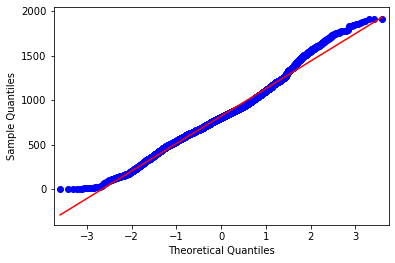

In [176]:
#We perform a qq plot then
sm.qqplot(hw_bcovid.headway, line='s') #.loc[hw_bcovid.hw_pos.isin([3,4])]
pylab.show()

## 2Dimensional Headways Plot

In [335]:
#Select data with dimension higher or equal to 2
unique_dates1 = hw_bcovid.loc[(hw_bcovid.hw_pos>1)&(hw_bcovid.direction==1)].datetime.unique().tolist()
unique_dates2 = hw_bcovid.loc[(hw_bcovid.hw_pos>1)&(hw_bcovid.direction==2)].datetime.unique().tolist()

hw_bcovid_2d_temp = hw_bcovid.loc[((((hw_bcovid.datetime.isin(unique_dates1)) & (hw_bcovid.direction == 1)) | \
                            ((hw_bcovid.datetime.isin(unique_dates2)) & (hw_bcovid.direction == 2)))) & \
                            (hw_bcovid.hw_pos<3)].sort_values('datetime')

hw_bcovid_2d_temp.head()

,line,direction,datetime,hw_pos,busA,busB,headway,busB_ttls
3906,1,2,2020-02-27 07:00:55.767621,1,117,119,1409,1923
3907,1,2,2020-02-27 07:00:55.767621,2,119,122,746,2670
3911,1,2,2020-02-27 07:01:50.598572,1,117,119,1419,1856
3912,1,2,2020-02-27 07:01:50.598572,2,119,122,754,2610
3916,1,2,2020-02-27 07:02:45.612884,1,117,119,1469,1809


In [370]:
h1 = hw_bcovid_2d_temp.loc[hw_bcovid_2d_temp.hw_pos == 1].headway.tolist()
h2 = hw_bcovid_2d_temp.loc[hw_bcovid_2d_temp.hw_pos == 2].headway.tolist()

hw_bcovid_2d = pd.DataFrame({'h1': h1,'h2': h2})

In [371]:
#Get confidence ellipse params
conf = 0.95
ellipse_params = get_parameters(hw_bcovid_2d,conf)
mus,ei_vecs,ei_vals = ellipse_params

In [388]:
#Draw confidence ellipse
fig = go.Figure()
x, y = ellipse(
    mus=mus, 
    ei_vecs=ei_vecs,
    ei_vals=ei_vals
)

def inside_apply(row) :
    return int(inside(ellipse_params,row.h1,row.h2))

hw_bcovid_2d['inside'] = hw_bcovid_2d.apply(inside_apply,axis=1)
    
#Scatter points
fig.add_trace(go.Scatter(
    name='2D Headways',
    x=hw_bcovid_2d.h1,
    y=hw_bcovid_2d.h2,
    mode=' markers',
    marker=dict(
        color=['green' if ins_ellip else 'black' for ins_ellip in hw_bcovid_2d.inside]
    )
))

#Confidence ellipse
fig.add_trace(go.Scatter(
    name='{}% Confidence Ellipse'.format(conf*100),
    x=x,
    y=y,
    mode='lines',
    line=dict(
        color='orange'
    )
))

#Update the layout
fig.update_layout(
    title='2 Dimensional Headways. Black points are the ones outside confidence interval.',
    showlegend=True
)
fig.show()

In [386]:
#Check if the point is inside or outside the ellipse
hw_bcovid_2d.describe()

,h1,h2,inside
count,2143.000,2143.000,2143.000
mean,826.801,805.091,0.926
std,313.433,258.748,0.261
min,5.000,5.000,0.000
25%,610.000,651.000,1.000
50%,807.000,821.000,1.000
75%,1023.000,965.000,1.000
max,1908.000,1917.000,1.000


## 3Dimensional Headways Plot

In [74]:
#Select data with dimension higher or equal to 3
unique_dates1 = hw_bcovid.loc[(hw_bcovid.hw_pos>2)&(hw_bcovid.direction==1)].datetime.unique().tolist()
unique_dates2 = hw_bcovid.loc[(hw_bcovid.hw_pos>2)&(hw_bcovid.direction==2)].datetime.unique().tolist()

hw_bcovid_3d = hw_bcovid.loc[((((hw_bcovid.datetime.isin(unique_dates1)) & (hw_bcovid.direction == 1)) | \
                            ((hw_bcovid.datetime.isin(unique_dates2)) & (hw_bcovid.direction == 2)))) & \
                            (hw_bcovid.hw_pos<4)]

h1 = hw_bcovid_3d.loc[hw_bcovid.hw_pos == 1].headway.tolist()
h2 = hw_bcovid_3d.loc[hw_bcovid.hw_pos == 2].headway.tolist()
h3 = hw_bcovid_3d.loc[hw_bcovid.hw_pos == 3].headway.tolist()

#Finally Create 3dimensional Dataframe
hw_bcovid_3d = pd.DataFrame({'h1': h1,'h2': h2,'h3': h3})
hw_bcovid_3d

,h1,h2,h3
0,665,1092,693
1,708,1114,682
2,685,1180,638
3,716,1040,596
4,704,1035,597
...,...,...,...
1118,794,991,830
1119,803,963,735
1120,773,979,706
1121,738,972,681


## Time series analysis of the headways
We can also detect anomalies by detecting strange behaviours in the headway along time.

In [53]:
hw_bcovid[hw_bcovid.headway<200]

,line,direction,datetime,hw_pos,busA,busB,headway,busB_ttls
4513,1,2,2020-02-27 08:33:30.810881,3,8322,119,2,3077
4521,1,2,2020-02-27 08:34:25.687390,3,119,8322,9,3032
4529,1,2,2020-02-27 08:35:20.672059,3,8322,119,18,2967
4536,1,2,2020-02-27 08:36:15.679434,3,119,8322,6,2919
4544,1,2,2020-02-27 08:37:10.690652,3,119,8322,6,2864
...,...,...,...,...,...,...,...,...
82145,1,2,2020-03-09 08:58:20.152590,1,123,111,167,1185
82153,1,2,2020-03-09 08:59:15.052439,1,123,111,143,1131
90360,1,2,2020-03-10 07:55:08.286865,1,8243,8241,156,167
107382,1,2,2020-03-12 08:05:09.705241,1,118,122,124,247


In [59]:
busA = 119 
busB = 120
direction = 1
hw_AB1 = hw_bcovid.loc[(hw_bcovid.busA==busA)&(hw_bcovid.busB==busB)&(hw_bcovid.direction==direction)]
hw_AB1 = hw_AB1.loc[(hw_AB1.datetime>datetime.datetime(2020,3,8))]
hw_AB1.head()

busA = 123 
busB = 111
direction = 2
hw_AB2 = hw_bcovid.loc[(hw_bcovid.busA==busA)&(hw_bcovid.busB==busB)&(hw_bcovid.direction==direction)]
hw_AB2 = hw_AB2.loc[(hw_AB2.datetime>datetime.datetime(2020,3,8))]
hw_AB2.head()

,line,direction,datetime,hw_pos,busA,busB,headway,busB_ttls
81878,1,2,2020-03-09 08:27:10.071766,3,123,111,164,2928
81886,1,2,2020-03-09 08:28:05.113239,3,123,111,149,2882
81894,1,2,2020-03-09 08:29:00.074228,3,123,111,183,2887
81902,1,2,2020-03-09 08:29:54.989181,3,123,111,189,2834
81909,1,2,2020-03-09 08:30:50.084357,3,123,111,194,2781


In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = hw_AB1.datetime,
    y = hw_AB1.headway,
    mode = 'lines+markers',
    line = dict(
        color = 'blue',
        width = 1.5
    )
))
fig.show()

In [63]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = hw_AB2.datetime,
    y = hw_AB2.headway,
    mode = 'lines+markers',
    line = dict(
        color = 'red',
        width = 1.5
    )
))
fig.show()